In [1]:

__metaclass__=type
import random
import csv
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

#define a class called 'Customer'
class Customer:
    def __init__(self,arrival_time,service_start_time,service_time, item):
        self.arrival_time=arrival_time
        self.service_start_time=service_start_time
        self.service_time=service_time
        self.service_end_time=self.service_start_time+self.service_time
        self.wait=self.service_start_time-self.arrival_time
        self.item = item
        
class Cashier:
    def __init__(self,serviceRate):
        self.serviceRate = serviceRate
        self.available = True
        self.ServiceEnd= -1
    def checkAvailability(self,currentTime):
        if(currentTime>self.ServiceEnd):
            self.available =True
        return self.available
    def serve(self,serviceStartTime,item):
        self.ServiceEnd = serviceStartTime + self.serviceRate
        self.available = False
        
        
class Store:
    def __init__(self,Name,Num_Customer,Mean_Delay,Mean_service_Delay,Num_cust_on_Manager_q, stock):
        self.Name=Name
        self.Num_Customer=Num_Customer
        self.Mean_Delay=Mean_Delay
        self.Mean_service_Delay=Mean_service_Delay
        self.Num_cust_on_Manager_q=Num_cust_on_Manager_q
        self.stock = stock

#Store In a simulation since you only make the store at the end of its simulation
class StoreInProgress:
    def __init__(self,stock_max):
        self.stock_max = stock_max
        self.stock_current = stock_max
        self.stock_sold = [0,0,0]
    def replenish(self,item, amount):
        self.stock_current[item] = self.stock_current[item] + amount
    
        
class Shelf:
    def __init__(self,):
        self.Name=Name
        self.Num_Customer=Num_Customer
        self.Mean_Delay=Mean_Delay
        self.Mean_service_Delay=Mean_service_Delay
        self.Num_cust_on_Manager_q=Num_cust_on_Manager_q
        
        
#a simple function to sample from negative exponential
def neg_exp(lambd):
    return random.expovariate(lambd)

def item_choose():
    return random.randint(0, 2)  # Random integer x, 1 <= x < 10

def Manager_Queue_Delay():
    return random.randint(10, 60)  # Random integer x, 1 <= x < 10


def StoreSim(lambd=False,mu=False,simulation_time=False):
    """
    This is the main function to call to simulate a store.
    """
    max_Stock = [25,25,25]
    #If parameters are not input prompt
    if not lambd:
        lambd=input('Inter arrival rate: ')
        lambd=int(lambd)
    if not mu:
        mu=input('Service rate: ')
        mu=int(mu)
    if not simulation_time:
        simulation_time=input('Total simulation time: ')
        simulation_time=int(simulation_time)

    #Initialise clock
    t=0

    #Initialise empty list to hold all data
    Customers=[]
    CustomerWait=[]
    Cashiers = []
    
    Cashiers.append(Cashier(5))
    Cashiers.append(Cashier(7))
    Cashiers.append(Cashier(3))
    
    Num_cust_on_Manager_q = 0
    Store1 = StoreInProgress(max_Stock)
#----------------------------------
#The actual simulation happens here:
    while t<simulation_time:
        item = item_choose()
        #calculate arrival date and service time for new customer
        if len(Customers)==0:
            arrival_time=neg_exp(lambd)
            service_start_time=arrival_time
            busy = False
            i =0
            #check if the item is in stock
            if Store1.stock_current[item]> 0:
                service_time=0
                available = False
                #look for an available cashier
                for cash in Cashiers:
                    if(cash.checkAvailability(service_start_time)):
                        cash.serve(service_start_time,item)
                        service_time=neg_exp(cash.serviceRate)
                        available = True
                        break
                
                #if no cashier is available wait for the next available Cashier
                if(not available):
                    minTime = Cashiers[0].ServiceEnd
                    chold = 0
                    for cash in range(len(Cashiers)):
                        if(Cashiers[cash].ServiceEnd< minTime):
                            minTime = Cashiers[cash].ServiceEnd
                            chold = cash
                    serviceTime= minTime
                    Cashiers[chold].serve(service_time,item)
                #Update Stock
                Store1.stock_current[item] = Store1.stock_current[item] - 1
                Store1.stock_sold[item] = Store1.stock_sold[item] + 1
            else:
                service_time=neg_exp(mu)+Manager_Queue_Delay()
                Num_cust_on_Manager_q = Num_cust_on_Manager_q+1
                #replenish stock if out
                
                Store1.replenish(item,10)
        else:
            arrival_time+=neg_exp(lambd)
            service_start_time=max(arrival_time,Customers[-1].service_end_time)
            if Store1.stock_current[item]> 0:
                service_time = 0
                available = False
                #look for an available cashier
                for cash in Cashiers:
                    if(cash.checkAvailability(service_start_time)):
                        cash.serve(service_start_time,item)
                        service_time=neg_exp(cash.serviceRate)
                        available = True
                        break
                
                #if no cashier is available wait for the next available Cashier
                if(not available):
                    minTime = Cashiers[0].ServiceEnd
                    chold = 0
                    for cash in range(len(Cashiers)):
                        if(Cashiers[cash].ServiceEnd< minTime):
                            minTime = Cashiers[cash].ServiceEnd
                            chold = cash
                    serviceTime= minTime
                    Cashiers[chold].serve(service_time,item)
                Store1.stock_current[item] = Store1.stock_current[item] - 1
                Store1.stock_sold[item] = Store1.stock_sold[item] + 1
            else:
                service_time=neg_exp(mu)+Manager_Queue_Delay()
                Num_cust_on_Manager_q = Num_cust_on_Manager_q+1
                Store1.replenish(item,10)

        #create new customer and add him to Customers list
        Customers.append(Customer(arrival_time,service_start_time,service_time,item))
        #increment clock till next end of service
        t=arrival_time
#----------------------------------

    #calculate summary statistics
    Waits=[a.wait for a in Customers]
    Mean_Wait=sum(Waits)/len(Waits)

    Total_Times=[a.wait+a.service_time for a in Customers]
    Mean_Delay=sum(Total_Times)/len(Total_Times)

    Service_Times=[a.service_time for a in Customers]
    Mean_Service_Delay=sum(Service_Times)/len(Service_Times)
    return Store('store',len(Customers),Mean_Delay,Mean_Service_Delay,Num_cust_on_Manager_q,Store1.stock_current)

In [2]:

        
def NetworkSim(num_store=False,simulation_time=False):
    """
    This is the main function to call to simulate the network.
    """

    #If parameters are not input prompt user
    if not num_store:
        num_store=input('Enter the number of Stores: ')
    
    if not simulation_time:
        simulation_time=input('Total simulation time: ')
        

    #Initialise empty list to collect store info
    Net_Stores=[]
    
    for i in range(num_store):
        Lambd = neg_exp(1)
        Mu = neg_exp(2)
        Net_Stores.append(StoreSim(Lambd, Mu, simulation_time))
    
    #map of medicine made
    j=0
    List_Mean_Delay =[]
    List_Num_Customer=[]
    List_Mean_service_Delay=[]
    List_Num_cust_on_Manager_q=[]

    print("\n%s Statistical Report %s\n" % (10*"=",10*"="))

    for store in Net_Stores:
        j = j+1
        List_Mean_Delay.append(store.Mean_Delay)
        List_Num_Customer.append(store.Num_Customer)
        List_Mean_service_Delay.append(store.Mean_service_Delay)
        List_Num_cust_on_Manager_q.append(store.Num_cust_on_Manager_q)

        print("")
        print("\n%s Summary for Store%d  %s\n" % (10*"=",j,10*"="))
        print("\t Mean number of Customer: %.02f\n" % store.Num_Customer)
        print("\t Mean Delay in Queue: %.02f\n" % store.Mean_Delay)
        print("\t Mean service time: %.02f\n" % store.Mean_service_Delay)
        print("\t Number Cust on Manager_q: %.02f\n" % store.Num_cust_on_Manager_q)
        print("\t Tynenol: %d\n" % store.stock[0])
        print("\t Cold Medicine: %d\n" % store.stock[1])
        print("\t Vitamins: %d\n" % store.stock[2])
    

    width = 0.35
    ind = np.arange(num_store) 

    plt.figure(1)  

    plt.subplot(221)
    plt.bar(ind, List_Mean_Delay, width, color='r')
    plt.title("Mean_Delay")

    plt.subplot(222)
    plt.bar(ind, List_Num_Customer, width, color='g')
    plt.title("Num_Customer")
     
    plt.subplot(223)
    plt.bar(ind, List_Mean_service_Delay, width, color='y')
    plt.title("Mean_service_Delay")

    plt.subplot(224)
    plt.bar(ind, List_Num_cust_on_Manager_q, width, color='b')
    plt.title("Num_cust_on_Manager_q")
    plt.show()
    
        #output summary statistics to screen
        #print ("")
        #print ("Store:", store.Name)
        #print ("Number of customers: ",store.Num_Customer)
        #print ("Mean Service Time: ",store.Mean_service_Delay)
        #print ("Mean Time in System: ",store.Mean_Delay)
        #print ("Number of Manager request: ",store.Num_cust_on_Manager_q)
        #print ("")
        


========== Statistical Report ==========



========== Summary for Store1  ==========

	 Mean number of Customer: 532.00

	 Mean Delay in Queue: 50.88

	 Mean service time: 5.32

	 Number Cust on Manager_q: 43.00

	 Tynenol: 1

	 Cold Medicine: 5

	 Vitamins: 10



========== Summary for Store2  ==========

	 Mean number of Customer: 21734.00

	 Mean Delay in Queue: 46587.47

	 Mean service time: 4.47

	 Number Cust on Manager_q: 1970.00

	 Tynenol: 5

	 Cold Medicine: 5

	 Vitamins: 1



========== Summary for Store3  ==========

	 Mean number of Customer: 1319.00

	 Mean Delay in Queue: 524.99

	 Mean service time: 3.68

	 Number Cust on Manager_q: 115.00

	 Tynenol: 6

	 Cold Medicine: 5

	 Vitamins: 10



========== Summary for Store4  ==========

	 Mean number of Customer: 5116.00

	 Mean Delay in Queue: 6825.18

	 Mean service time: 3.51

	 Number Cust on Manager_q: 460.00

	 Tynenol: 10

	 Cold Medicine: 9

	 Vitamins: 0



========== Summary for Store5  ==========

	 Mean numb

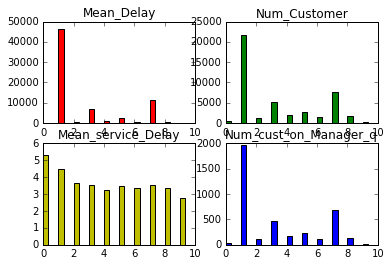

In [6]:
NetworkSim(10, 4000)